# Sequence Analysis: Arsenal, 2003-04

This workflow uses data sourced from [Statsbomb open data](https://statsbomb.com/what-we-do/hub/free-data/). It aims to identify common events and sequences of events which immediately precede shots (incl goals) and visualise these for the purpose of informing tactics.

[API usage instructions](https://github.com/statsbomb/statsbombpy/tree/master/statsbombpy)<br>

[PrexfixSpan-py](https://github.com/chuanconggao/PrefixSpan-py)<br>

Up the Gunners

Import libraries

Retrieve data

Clean and prepare data

Explore data

    * events
    
    * leading events
    
Analysis

In [1]:
# import libraries
from statsbombpy import sb
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from prefixspan import PrefixSpan
import pandas as pd
from scipy.stats import rankdata
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
# read event data for all 03/04 premier league games (only Arsenal available free)

import warnings
warnings.filterwarnings('ignore')

all_events = sb.competition_events(
    country="England",
    division= "Premier League",
    season="2003/2004",
    gender="male"
)

/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarni

## Data Preparation and Cleaning

In [53]:
# identify columns of interest

#list(all_events)

req_cols=['match_id','index','type','team','player','player_id',
          'position','shot_statsbomb_xg', 'shot_outcome','location', 
          'pass_end_location','carry_end_location', 'pass_recipient']

events=all_events[req_cols]

In [54]:
events=events[events['team']=='Arsenal']


In [55]:
# clean player_id
events['player_id'] = events['player_id'].fillna('00000') # replace NAs
events['player_id'] = events['player_id'].astype(str).str.split('.', expand=True)[0] # .0

# split location coordinates to X and Y cols
events['location_x'] = events['location'].str[0]
events['location_y'] = events['location'].str[1]
events['pass.end_location_x'] = events['pass_end_location'].str[0]
events['pass.end_location_y'] = events['pass_end_location'].str[1]
events['carry.end_location_x'] = events['carry_end_location'].str[0]
events['carry.end_location_y'] = events['carry_end_location'].str[1]

# drop orginal cols
events = events.drop(['location', 'pass_end_location', 'carry_end_location'], axis=1)

# add type_id column
label_encoder = LabelEncoder() # Create an instance of LabelEncoder
encoded_column = label_encoder.fit_transform(events['type']) # Fit the encoder on the categorical column
encoded_column_int = ['{:02d}'.format(val) for val in encoded_column] # Add leading 0s
events['type_id'] = encoded_column_int # Create a new column with the encoded values

# add column combining type and player
events["type_player"] = events["type_id"].astype(str) + events["player_id"].astype(str)

#remove unwanted events
#match_1_events = match_1_events[match_1_events['type'] != 'Carry']
#match_1_events = match_1_events[match_1_events['type'] != 'Ball Receipt*']

# map positions to broader positions
position_mapping = {
    'Right Back': 'Defender',
    'Left Back': 'Defender',
    'Left Midfield': 'Midfielder',
    'Right Midfield': 'Midfielder',
    'Left Center Forward': 'Attacker',
    'Right Center Forward': 'Attacker',
    'Left Defensive Midfield': 'Midfielder',
    'Right Defensive Midfield': 'Midfielder',
    'Left Center Back': 'Defender',
    'Right Center Back': 'Defender',
    'Left Center Midfield': 'Midfielder',
    'Right Center Midfield': 'Midfielder',
    'Goalkeeper': 'Goalkeeper',
    'Center Forward': 'Attacker',
    'Center Defensive Midfield': 'Midfielder',
    'Right Wing': 'Attacker',
    'Left Wing': 'Attacker',
    'Center Attacking Midfield': 'Midfielder',
    'Left Wing Back': 'Defender',
    'Right Attacking Midfield': 'Midfielder',
    'Center Back': 'Defender',
    'Left Attacking Midfield': 'Midfielder',
    'Right Wing Back': 'Defender',
    'Center Midfield': 'Midfielder'
}

events['mapped_position'] = events['position'].map(position_mapping)

In [56]:
events=events.sort_values(by=['match_id', 'index']).reset_index(drop=True)


In [60]:
# for each 'shot' type.name, create a list of the preceding n events. Append each list to a master list.
# also create a list of event indexes.

shot_events = []
event_indexes = []
play_outcome = []
play_xG = []
for i, row in events.iterrows():
    if row['type'] == 'Shot':
        outcome = row['shot_outcome']
        xG = row['shot_statsbomb_xg']
        start_index = max(0, i - 10)  # Calculate the start index, ensuring it doesn't go below 0
        indexes = list(range(start_index, i))
        event_indexes.extend(indexes)
        single_shot_events=[]
        for j in indexes:
            event=events['type_player'][j]
            single_shot_events.append(event)
            play_outcome.append(outcome)
            play_xG.append(xG)
        shot_events.append(single_shot_events)

In [61]:
# get indexes that do not lead to shot events - general play. This is used for comparison plots

all_indexes = events.index.values
event_indexes_array = np.array(event_indexes)
gen_play_indexes = np.setdiff1d(all_indexes, event_indexes_array)

In [62]:
# get full leading event data with event indexes and attach shot outcomes

leading_events=events.loc[event_indexes]
gen_play_events = events.loc[gen_play_indexes]
leading_events['play_outcome'] = play_outcome 
leading_events['play_xG'] = play_xG
leading_events['play_xG_ranked'] = rankdata(play_xG) / (len(play_xG) + 1)

# create type and player keys
type_key = leading_events[['type', 'type_id']].drop_duplicates().reset_index(drop=True)
player_key = leading_events[['player', 'player_id']].drop_duplicates().reset_index(drop=True)

## Data Exploration

We are interested in the events that occur in the lead up to shots. However, shots themselves can vary in terms of the danger they pose to the opposition. We can investigate this using the shot_outcome and shot_statsbomb_xg variables.

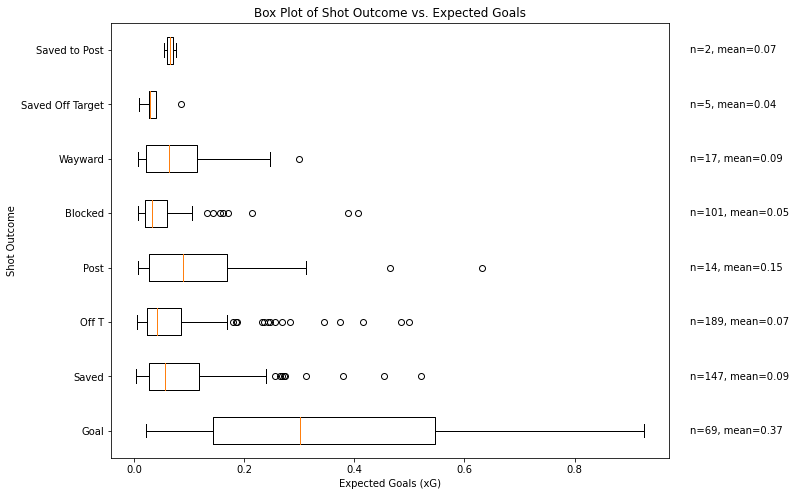

In [46]:
# box plot - xG by shot outcome 
all_shots=events[events['type']=='Shot']
shot_outcome = all_shots['shot_outcome']
shot_statsbomb_xg = all_shots['shot_statsbomb_xg']

# Group the shot_statsbomb_xg data based on shot_outcome
data = [shot_statsbomb_xg[shot_outcome == outcome] for outcome in shot_outcome.unique()]

# Create a horizontal box plot with a larger figure size
plt.figure(figsize=(10, 8))
box_plot = plt.boxplot(data, labels=shot_outcome.unique(), vert=False)

# Set labels and title
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Shot Outcome')
plt.title('Box Plot of Shot Outcome vs. Expected Goals')

# Add counts and mean xG to the plot
for i, outcome in enumerate(shot_outcome.unique()):
    count = len(data[i])
    mean_xg = np.mean(data[i])
    plt.text(1.01, i + 1, f'n={count}, mean={mean_xg:.2f}', va='center', ha='left')
# Display the plot
plt.show()

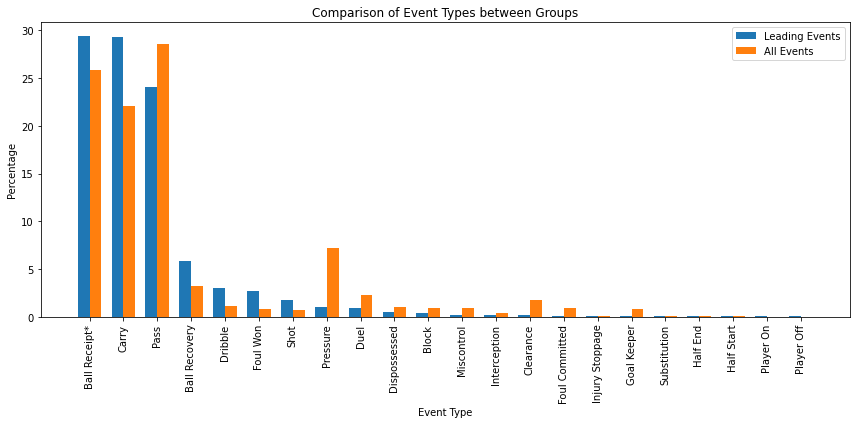

In [345]:
# explore the difference between events that lead to shots and general play

leading_group=leading_events['type'].value_counts()
all_events_group=gen_play_events['type'].value_counts()

# Calculate the total counts for each group
group1_total = leading_group.sum()
group2_total = all_events_group.sum()

# Calculate the percentages for each group
group1_percentages = leading_group / group1_total * 100
group2_percentages = all_events_group / group2_total * 100

# Extract the categories and their percentages from both groups
categories = group1_percentages.index
group1_percentages = group1_percentages.values
group2_percentages = group2_percentages[categories].values

# Calculate the x-axis positions for the bars
x = np.arange(len(categories))

# Width of the bars
bar_width = 0.35

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars for Group 1
rects1 = ax.bar(x - bar_width/2, group1_percentages, bar_width, label='Leading Events')

# Plot the bars for Group 2
rects2 = ax.bar(x + bar_width/2, group2_percentages, bar_width, label='All Events')

# Set the x-axis labels and title
ax.set_xlabel('Event Type')
ax.set_ylabel('Percentage')
ax.set_title('Comparison of Event Types between Groups')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=90)

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [346]:
# Of course, we're also interest in which players appear most influential in the lead up to shots on goal:

involvements=leading_events['player'].value_counts()

player
Thierry Henry                       709
Robert Pirès                        366
Dennis Bergkamp                     238
Fredrik Ljungberg                   205
Patrick Vieira                      196
Ray Parlour                         147
Ashley Cole                         128
Gilberto Aparecido da Silva         126
Eduardo César Daude Gaspar          106
Laureano Bisan-Etame Mayer          100
José Antonio Reyes Calderón          97
Sylvain Wiltord                      74
Kolo Habib Touré                     65
Nwankwo Christian Kanu               63
Jérémie Aliadière                    29
Sulzeer Jeremiah ''Sol' Campbell     25
Gaël Clichy                          14
Jens Lehmann                         12
Pascal Cygan                         12
David Bentley                         5
Martin Keown                          1
Name: count, dtype: int64

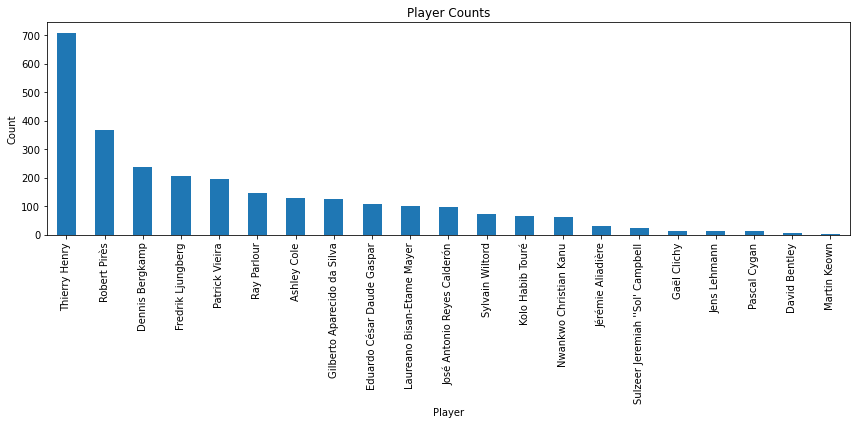

In [347]:
# Plot the series
plt.figure(figsize=(12, 6))
involvements.plot(kind='bar')
plt.xlabel('Player')
plt.ylabel('Count')
plt.title('Player Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [67]:
# Lets look at this again but accounting for minutes played. We will compare by positions.
mode_positions = events.groupby('player')['mapped_position'].apply(lambda x: x.mode()[0]) # get the mode position for each player
mode_positions

player
Ashley Cole                           Defender
David Bentley                       Midfielder
Dennis Bergkamp                       Attacker
Eduardo César Daude Gaspar          Midfielder
Fredrik Ljungberg                   Midfielder
Gaël Clichy                           Defender
Gilberto Aparecido da Silva         Midfielder
Jens Lehmann                        Goalkeeper
José Antonio Reyes Calderón           Attacker
Jérémie Aliadière                     Attacker
Kolo Habib Touré                      Defender
Laureano Bisan-Etame Mayer            Defender
Martin Keown                          Defender
Nwankwo Christian Kanu                Attacker
Pascal Cygan                          Defender
Patrick Vieira                      Midfielder
Ray Parlour                         Midfielder
Robert Pirès                        Midfielder
Sulzeer Jeremiah ''Sol' Campbell      Defender
Sylvain Wiltord                       Attacker
Thierry Henry                         Attacker
Name: 

In [68]:
import warnings
warnings.filterwarnings('ignore')

# Minutes played data. Start by loading the match data for the Premier League in 2003-04 season
matches = sb.matches(competition_id=2, season_id=44)

# function to unpack 'positions' column which contains minutes played details
def unpack_positions(row):
    if len(row['positions']) > 0:
        pos_data_from = row['positions'][0]
        pos_data_to = row['positions'][-1]
        if pos_data_to['to'] is None:
            pos_data_to['to']='90'
        from_value=int(pos_data_from['from'][:2])
        to_value=int(pos_data_to['to'][:2])
        mins_played=to_value-from_value
        return pd.Series({'from': from_value, 'to': to_value, 'mins_played': mins_played})
    else:
        return pd.Series({'from': 0, 'to': 0, 'mins_played': 0})

lineup_data=[]

for match_id in matches['match_id']:
    ars_lineup=sb.lineups(match_id)['Arsenal']
    ars_lineup[['from', 'to', 'mins_played']] = ars_lineup.apply(unpack_positions, axis=1)
    lineup_data.append(ars_lineup)

# concat and groupby sum
arsenal_lineups = pd.concat(lineup_data)
minutes_played = arsenal_lineups.groupby('player_name')['mins_played'].sum().reset_index()
minutes_played = minutes_played.rename(columns={'player_name': 'player'})
minutes_played

,player,mins_played
0,Ashley Cole,2842
1,David Bentley,60
2,Dennis Bergkamp,1762
3,Eduardo César Daude Gaspar,1481
4,Fredrik Ljungberg,2225
5,Gaël Clichy,656
6,Gilberto Aparecido da Silva,2544
7,Graham Stack,0
8,Jens Lehmann,3420
9,José Antonio Reyes Calderón,652


In [350]:
mins_inv_pos = minutes_played.merge(involvements, on='player').merge(mode_positions, on='player')
mins_inv_pos = mins_inv_pos.rename(columns={'count': 'involvements'})
mins_inv_pos.head()

,player,mins_played,involvements,mapped_position
0,Ashley Cole,2842,128,Defender
1,David Bentley,60,5,Midfielder
2,Dennis Bergkamp,1762,238,Attacker
3,Eduardo César Daude Gaspar,1481,106,Midfielder
4,Fredrik Ljungberg,2225,205,Midfielder


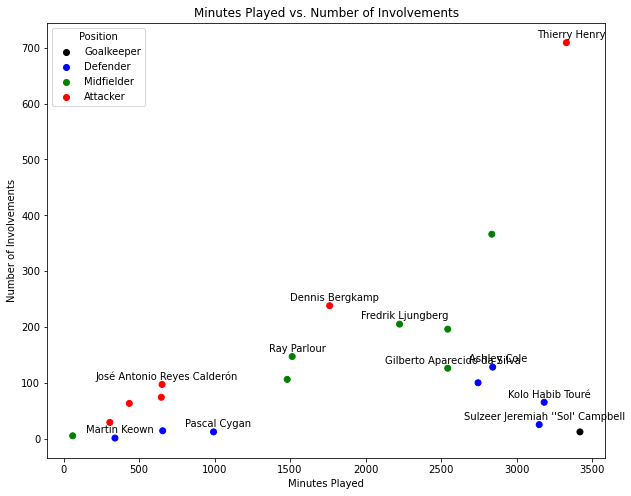

In [351]:
# plot

label_encoder = LabelEncoder() #Create an instance of LabelEncoder
encoded_positions = label_encoder.fit_transform(mins_inv_pos['mapped_position']) #Encode the 'position' column
position_colors = {'Goalkeeper': 'black', 'Defender': 'blue', 'Midfielder': 'green', 'Attacker': 'red'} #Create a dictionary to map positions to colors
colors = [position_colors[mapped_position] for mapped_position in mins_inv_pos['mapped_position']] #Create a list of colors based on the encoded positions

plt.figure(figsize=(10, 8))
plt.scatter(mins_inv_pos['mins_played'], mins_inv_pos['involvements'], c=colors)
for i, row in mins_inv_pos.iterrows():
    if i % 2 == 0: # Label every 5th point
        plt.annotate(row['player'], (row['mins_played'], row['involvements']), textcoords="offset points", xytext=(5,5), ha='center')
plt.xlabel('Minutes Played')
plt.ylabel('Number of Involvements')
plt.title('Minutes Played vs. Number of Involvements')
for position, color in position_colors.items():
    plt.scatter([], [], c=color, label=position)
    plt.legend(title='Position')
    
plt.show()

## Analysis

Now lets analyse the sequences

In [381]:
# use ps algorithm on shot events list of lists.
ps = PrefixSpan(shot_events)

results = ps.frequent(100)

In [382]:
# sort results by support count (desc)
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)
sorted_results

[(215, ['0215516']),
 (215, ['0515516']),
 (161, ['0215516', '0515516']),
 (120, ['2315516']),
 (116, ['2319312'])]

In [383]:
# select most common event
common_event=str(sorted_results[0][1][0])
common_event

'0215516'

In [355]:
# find data on all occurences of most common event
common_event_data=leading_events[leading_events['type_player']==common_event].reset_index(drop=True)
common_event_data.head()

,match_id,index,type,team,player,player_id,position,shot_statsbomb_xg,shot_outcome,pass_recipient,...,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_id,type_player,mapped_position,play_outcome,play_xG,play_xG_ranked
0,3749052,472,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,02,0215516,Attacker,Saved,0.007914,0.045204
1,3749052,472,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,02,0215516,Attacker,Off T,0.125604,0.758177
2,3749052,1486,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,02,0215516,Attacker,Saved,0.147070,0.798603
3,3749052,2091,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,02,0215516,Attacker,Goal,0.316198,0.919882
4,3749052,2172,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,02,0215516,Attacker,Saved,0.018697,0.144432


In [356]:
n_shots=len(shot_events)
n_common_events=len(common_event_data)
player_name=common_event_data.loc[0]['player']
type_name=common_event_data.loc[0]['type']
pc_common_event=round((n_common_events/n_shots)*100,2)

print(f"In the 2003-04 season, Arsenal had {n_shots} shots. {pc_common_event}% of these were preceeded by a {type_name} by {player_name}.")

In the 2003-04 season, Arsenal had 544 shots. 39.89% of these were preceeded by a Ball Receipt* by Thierry Henry.


In [357]:
common_event_data['play_outcome'].value_counts()

play_outcome
Off T            76
Saved            74
Goal             27
Blocked          25
Wayward           7
Post              7
Saved to Post     1
Name: count, dtype: int64

In [358]:
outcome_mapping = {
    'Goal': 'red',
    'Post': 'orange',
    'Wayward': 'yellow',
    'Saved': 'green',
    'Off T': 'lightblue',
    'Saved to Post': 'blue',
    'Blocked': 'purple',
    'Saved Off Target': 'black'
}

common_event_data['outcome_color'] = common_event_data['play_outcome'].map(outcome_mapping)

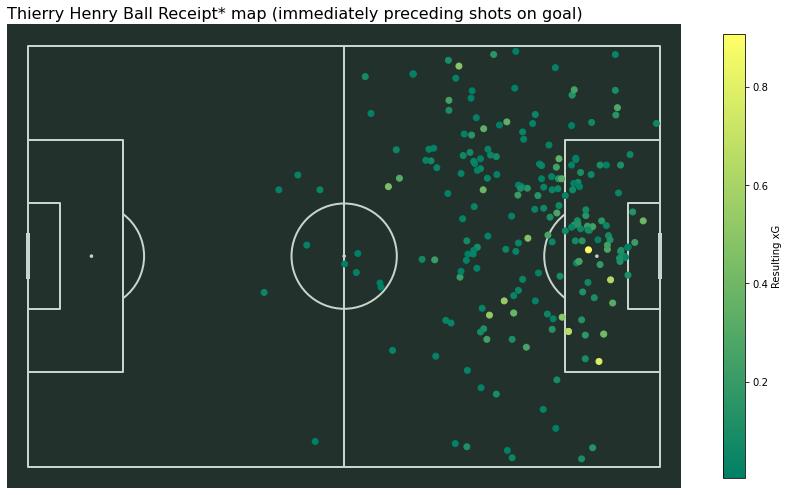

In [359]:
# visualise events
cmap_scheme='summer'
cmap = plt.cm.get_cmap(cmap_scheme)
color_by='play_xG'
colors = cmap(common_event_data[color_by])

event_id=common_event[:2]
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 8))

if event_id=='02':
    ax.scatter(common_event_data['location_x'], common_event_data['location_y'], c=common_event_data[color_by],
               cmap=cmap_scheme, zorder=10)
elif event_id=='23':
    ax.quiver(common_event_data['location_x'], common_event_data['location_y'], 
             common_event_data['pass.end_location_x'] - common_event_data['location_x'], common_event_data['pass.end_location_y'] - common_event_data['location_y'], 
             color=colors, scale_units='xy', angles='xy', scale=1, width=0.002)
elif event_id=='05': 
    ax.quiver(common_event_data['location_x'], common_event_data['location_y'], 
             common_event_data['carry.end_location_x'] - common_event_data['location_x'], common_event_data['carry.end_location_y'] - common_event_data['location_y'], 
             color=colors, scale_units='xy', angles='xy', scale=1, width=0.002)
else:
    print("Event must be a ball receipt, carry or pass")
ax.set_title(f"{player_name} {type_name} map (immediately preceding shots on goal)", fontsize=16, loc='left')
ax.title.set_position([0.5, 1.05])

# Add colorbar legend
sm = ScalarMappable(cmap=cmap)
sm.set_array(common_event_data[color_by])
plt.colorbar(sm, ax=ax, shrink=0.8, label="Resulting xG")
plt.show()


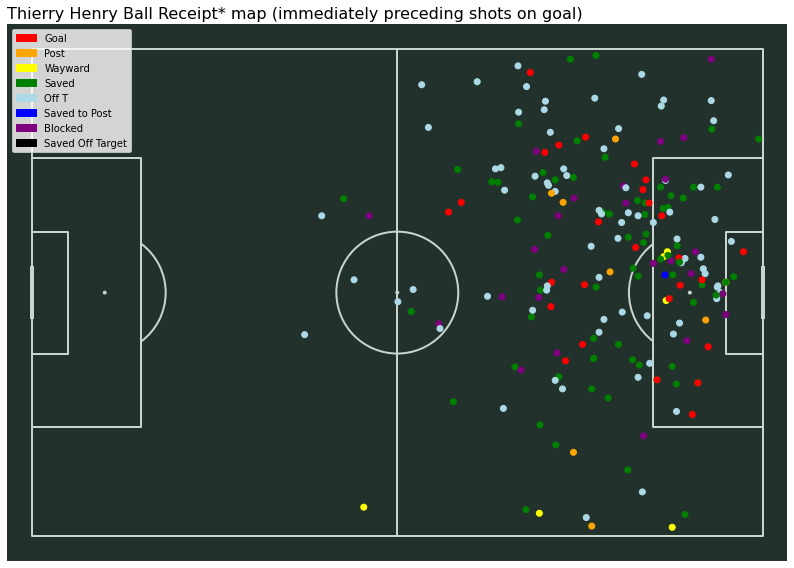

In [360]:
import matplotlib.patches as mpatches


event_id=common_event[:2]
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 8))

if event_id=='02':
    ax.scatter(common_event_data['location_x'], common_event_data['location_y'], c=common_event_data['outcome_color'], zorder=10)
else:
    print("Event must be a ball receipt, carry or pass")
ax.set_title(f"{player_name} {type_name} map (immediately preceding shots on goal)", fontsize=16, loc='left')
ax.title.set_position([0.5, 1.05])

handles = [mpatches.Patch(color=color, label=outcome) for outcome, color in outcome_mapping.items()]
ax.legend(handles=handles, loc='upper left')

plt.show()

In [478]:
# caveats

# good opportunities != shots and xG. Martinelli vs Liverpool
# For example, a counter attacking 3v1 situation may appear a good goal scoring opportunity. However, 
# should the attacker in possession fail to execute their pass to a teammate, a shot (and cosequently, xG) 
# may not be recorded

In [479]:
from collections import Counter

# Flatten the sequences into individual items
items = [item for sublist in shot_events for item in sublist]

# Calculate the frequency of each subsequence
subsequence_length = 4  # Set the length of subsequences you want to find
frequencies = Counter(tuple(items[i:i+subsequence_length]) for i in range(len(items)-subsequence_length+1))

# Find the most common subsequences and their frequencies
most_common = frequencies.most_common()

# Print the top 10 most common subsequences
for subsequence, count in most_common[:20]:
    print(f"Subsequence: {subsequence}, Frequency: {count}")


Subsequence: ('0519312', '2319312', '0215516', '0515516'), Frequency: 58
Subsequence: ('0219312', '0519312', '2319312', '0215516'), Frequency: 49
Subsequence: ('0215516', '0515516', '0815516', '0515516'), Frequency: 41
Subsequence: ('0515515', '2315515', '0219312', '0519312'), Frequency: 35
Subsequence: ('0219312', '0519312', '2319312', '0212529'), Frequency: 34
Subsequence: ('0515515', '2315515', '0215516', '0515516'), Frequency: 34
Subsequence: ('0215515', '0515515', '2315515', '0219312'), Frequency: 33
Subsequence: ('2315515', '0219312', '0519312', '2319312'), Frequency: 33
Subsequence: ('0215515', '0515515', '2315515', '0215516'), Frequency: 33
Subsequence: ('2340221', '0240222', '0540222', '2340222'), Frequency: 32
Subsequence: ('2319312', '0212529', '0512529', '2312529'), Frequency: 32
Subsequence: ('0512529', '2312529', '0219312', '0519312'), Frequency: 31
Subsequence: ('2312529', '0219312', '0519312', '2319312'), Frequency: 31
Subsequence: ('0515754', '2315754', '0215516', '051

In [338]:
# player_key

In [384]:
type_key

,type,type_id
0,Pass,23
1,Ball Receipt*,02
2,Carry,05
3,Shot,29
4,Pressure,26
5,Ball Recovery,03
6,Foul Won,13
7,Duel,10
8,Clearance,06
9,Dribble,08
